In [1]:
%cd C:\Users\inesl\Documents\Thesis\Code\Overcooked\overcooked-gym
import pandas as pd
import numpy as np
from get_stats import *
from plots import *
from scipy.stats import mannwhitneyu, shapiro, norm

C:\Users\inesl\Documents\Thesis\Code\Overcooked\overcooked-gym


In [2]:
#Effect Size r less than 0.3 -> small effect
#Effect Size r between 0.3 and 0.5 -> medium effect
#Effect Size r greater than 0.5 -> large effect

from math import sqrt
def mann_whitney_effect(x, y, U):
    n1 = x.shape[-1]
    n2 = y.shape[-1]
    mu = n1*n2/2
    std = sqrt(n1*n2*(n1+n2+1)/12)
    z = (U-mu)/std
    return abs(z/sqrt(n1+n2))

First we download the results from our experiments with each of the two algorithms:

In [3]:
dqn_results_by_teammate = [[],[],[],[],[]]

for r in range(1,11):
    dqn_results = get_dqn_test_results(r)
    for i in range(5):
        dqn_results_by_teammate[i].append(dqn_results.loc[dqn_results['teammate_id'] == i].loc[:, 'reward_ep0':].values)
        
for i in range(5):
    dqn_results_by_teammate[i] = np.concatenate(dqn_results_by_teammate[i], axis=1)

dqn_total_results = np.concatenate(dqn_results_by_teammate,axis=1)

In [4]:
distillation_results_by_teammate = [[],[],[],[],[]]

for r in range(1,11):
    distillation_results = get_distillation_test_results(r)
    for i in range(5):
        distillation_results_by_teammate[i].append(distillation_results.loc[distillation_results['teammate_id'] == i].loc[:, 'reward_ep0':].values)
        
for i in range(5):
    distillation_results_by_teammate[i] = np.concatenate(distillation_results_by_teammate[i], axis=1)

distillation_total_results = np.concatenate(distillation_results_by_teammate,axis=1)

We then compute the basic statistics for these results:

In [5]:
print(f"  Distilled Agent - average: {np.average(distillation_total_results)}; std: {np.std(distillation_total_results)}")
print(f"  DQN - average: {np.average(dqn_total_results)}; std: {np.std(dqn_total_results)}")

  Distilled Agent - average: 10.4576; std: 6.113313523777428
  DQN - average: 10.7294; std: 5.928488478524691


Then we visualize the plots of the two distributions and observe that they may not be normal.

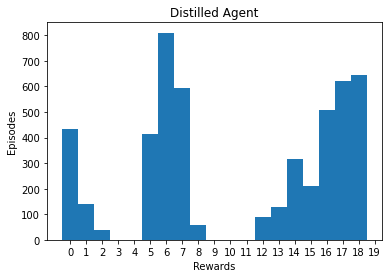

In [6]:
plot_histogram("Distilled Agent", distillation_total_results.flatten())

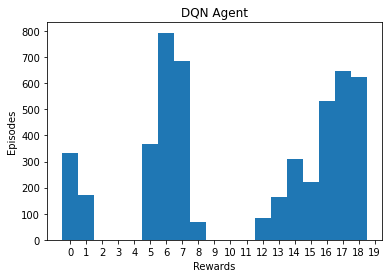

In [7]:
plot_histogram("DQN Agent", dqn_total_results.flatten())

The Shapiro-Wilk test is thus performed to test whether each of these distributions is normal.

In [8]:
shapiro(distillation_total_results)

ShapiroResult(statistic=0.8698444962501526, pvalue=0.0)

In [9]:
shapiro(dqn_total_results)

ShapiroResult(statistic=0.8701794147491455, pvalue=0.0)

With such a low p value it is safe to reject that these two distributions are normal. Thus we turn to the Mann-Whitney U test two compare these two distributions:

H0: the distributions are identical
H1: the distributions are not identical

In [10]:
U, p = mannwhitneyu(distillation_total_results.flatten(), dqn_total_results.flatten())
print(p)

0.017911937129520942


As can be seen, there seems to be a difference between the two distributions. We proceed to compare DQNs and the distilled networks. We proceed to compute the effect of that difference:

In [11]:
mann_whitney_effect(distillation_total_results.flatten(), dqn_total_results.flatten(), U)

0.023523399363770472

As can be seen, the effect size is very small (effect sizes smaller than 0.3 are considered small).

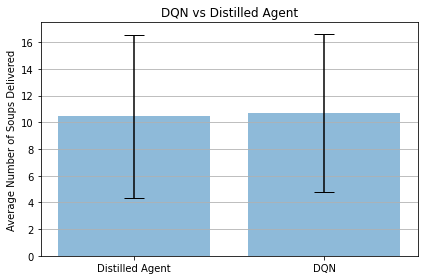

In [12]:
bar_plots_comparing_a_pair_of_means([np.average(distillation_total_results), np.average(dqn_total_results)], [np.std(distillation_total_results), np.std(dqn_total_results)], ["Distilled Agent", "DQN"], "DQN vs Distilled Agent", save_file=None)

# Results discriminated by teammates:

We will now look at different teammates individualy:

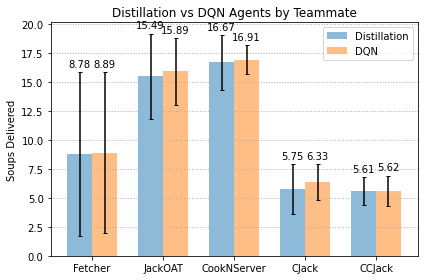

In [13]:
distillation_means_by_teammate = [np.average(tr) for tr in distillation_results_by_teammate]
distillation_std_by_teammate = [np.std(tr) for tr in distillation_results_by_teammate]
dqn_means_by_teammate = [np.average(tr) for tr in dqn_results_by_teammate]
dqn_std_by_teammate = [np.std(tr) for tr in dqn_results_by_teammate]
teammates_labels = ["Fetcher", "JackOAT", "CookNServer", "CJack", "CCJack"]

bar_plots_comparing_multiple_pairs_of_means(distillation_means_by_teammate, distillation_std_by_teammate, 
                                            dqn_means_by_teammate, dqn_std_by_teammate,
                                            "Distillation", "DQN", teammates_labels, "Distillation vs DQN Agents by Teammate",
                                                save_file=None)

In [14]:
for t in range(5):
    print(f"TEAMMATE {t} ({teammates_labels[t]})")
    dist_t = distillation_results_by_teammate[t]
    dqn_t = dqn_results_by_teammate[t]
    print(f"  Distilled Agent - average: {np.average(dist_t)}; std: {np.std(dist_t)}, Shapiro-Wilk test: {shapiro(dist_t)[1]}")
    print(f"  DQN - average: {np.average(dqn_t)}; std: {np.std(dqn_t)}, Shapiro-Wilk test: {shapiro(dqn_t)[1]}")
    #print(f"  p-value: {p_value_mean_difference(dist_t, dqn_t)}")
    #print(f"  Cohen's d test: {cohens_d_effect_size(dist_t, dqn_t)}")
    print(f"  ")

TEAMMATE 0 (Fetcher)
  Distilled Agent - average: 8.775; std: 7.034939587516015, Shapiro-Wilk test: 3.3218346221399376e-38
  DQN - average: 8.894; std: 6.944405230111503, Shapiro-Wilk test: 8.932779968856181e-38
  
TEAMMATE 1 (JackOAT)
  Distilled Agent - average: 15.489; std: 3.6731293198034836, Shapiro-Wilk test: 1.9990783762211408e-40
  DQN - average: 15.892; std: 2.8789470297315303, Shapiro-Wilk test: 2.917223143031404e-41
  
TEAMMATE 2 (CookNServer)
  Distilled Agent - average: 16.667; std: 2.3371159577564824, Shapiro-Wilk test: 0.0
  DQN - average: 16.907; std: 1.2297768090186119, Shapiro-Wilk test: 4.504614043418557e-41
  
TEAMMATE 3 (CJack)
  Distilled Agent - average: 5.749; std: 2.144294522681061, Shapiro-Wilk test: 1.028735241614778e-40
  DQN - average: 6.333; std: 1.5550276524872475, Shapiro-Wilk test: 1.401298464324817e-45
  
TEAMMATE 4 (CCJack)
  Distilled Agent - average: 5.608; std: 1.1951301184389924, Shapiro-Wilk test: 1.1307077308636949e-41
  DQN - average: 5.621; st

As can bee seen, neither of these distributions is considered normal by the Shapiro-Wilk test. Thus, we use the Mann-Whitney U test to compare each pair of distributions.

In [15]:
for t in range(5):
    print(f"TEAMMATE {t} ({teammates_labels[t]})")
    dist_t = distillation_results_by_teammate[t]
    dqn_t = dqn_results_by_teammate[t]
    print(f"  Distilled Agent - average: {np.average(dist_t)}; std: {np.std(dist_t)}")
    print(f"  DQN - average: {np.average(dqn_t)}; std: {np.std(dqn_t)}")
    print(f"  Mann-Whitney U test: {mannwhitneyu(dist_t.flatten(), dqn_t.flatten())[1]}")

TEAMMATE 0 (Fetcher)
  Distilled Agent - average: 8.775; std: 7.034939587516015
  DQN - average: 8.894; std: 6.944405230111503
  Mann-Whitney U test: 0.10087038702709462
TEAMMATE 1 (JackOAT)
  Distilled Agent - average: 15.489; std: 3.6731293198034836
  DQN - average: 15.892; std: 2.8789470297315303
  Mann-Whitney U test: 0.9133481706720967
TEAMMATE 2 (CookNServer)
  Distilled Agent - average: 16.667; std: 2.3371159577564824
  DQN - average: 16.907; std: 1.2297768090186119
  Mann-Whitney U test: 0.5626863141939392
TEAMMATE 3 (CJack)
  Distilled Agent - average: 5.749; std: 2.144294522681061
  DQN - average: 6.333; std: 1.5550276524872475
  Mann-Whitney U test: 1.846216093948204e-08
TEAMMATE 4 (CCJack)
  Distilled Agent - average: 5.608; std: 1.1951301184389924
  DQN - average: 5.621; std: 1.2974432550211974
  Mann-Whitney U test: 0.18851107034431835


In [16]:
for t in range(5):
    print(f"TEAMMATE {t} ({teammates_labels[t]})")
    dist_t = distillation_results_by_teammate[t]
    dqn_t = dqn_results_by_teammate[t]
    print(f" Mann-Whitney U test: {round(mannwhitneyu(dist_t.flatten(), dqn_t.flatten())[1], 10)}")

TEAMMATE 0 (Fetcher)
 Mann-Whitney U test: 0.100870387
TEAMMATE 1 (JackOAT)
 Mann-Whitney U test: 0.9133481707
TEAMMATE 2 (CookNServer)
 Mann-Whitney U test: 0.5626863142
TEAMMATE 3 (CJack)
 Mann-Whitney U test: 1.85e-08
TEAMMATE 4 (CCJack)
 Mann-Whitney U test: 0.1885110703


The only teammate in which there seems to be a difference between the distributions seems to be the ClockwiseJack. For all the remaining teammates, we cannot reject the hypothesis that the DQNs and the distilled agents perform similarly at a significance level smaller than 10%. It is worth looking at the effect of the difference between the DQN agent and the distilled agent when playing with the ClockiwiseJack.

In [17]:
dist_3 = distillation_results_by_teammate[3]
dqn_3 = dqn_results_by_teammate[3]
mann_whitney_effect(dist_3.flatten(), dqn_3.flatten(), mannwhitneyu(dist_3.flatten(), dqn_3.flatten())[0])

0.11211014140164774

Thus, despite there being a difference between the DQN and the distilled agent for teammate 3, that difference is considered small.

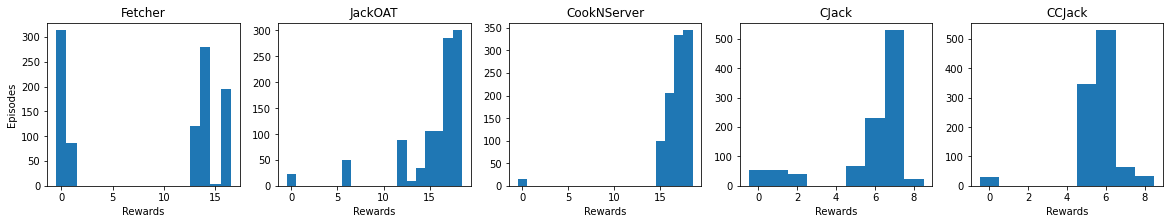

In [18]:
plot_histograms(distillation_results_by_teammate, teammates_labels)

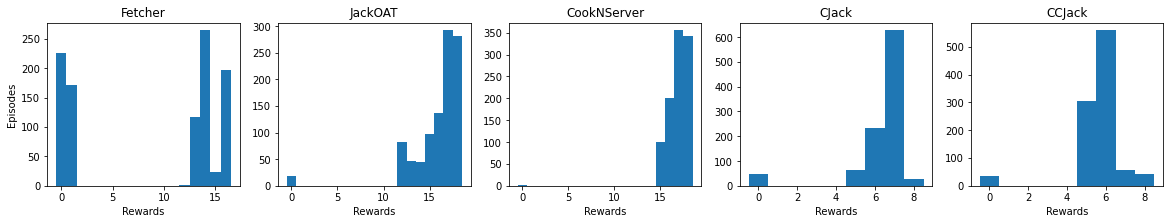

In [19]:
plot_histograms(dqn_results_by_teammate, teammates_labels)